# Fudan RPML Assignment1: Machine Learning Meets Fashion

![Machine Learning Meets Fashion](./img/ml_meets_fashion.jpg)

*Your name and Student ID: [李培基], [20307140044]*

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.*

In this assignment, you will use what you have learned to tackle some pratical problems. Fashion MNIST dataset[1] is the MNIST-like fashion product database for image classification you will play with this time. It originally consists of a training set of 60000 examples and a test set of 10000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. 

To make this task more realistic, we selected 14600 labeled examples from the training set and did a little processing. You have to do this image classifictaion task with our new dataset. 

You have to impletement several standard classification methods in the './fudanPRML' folder:
- K-nearest Neighbor (15 points)
- Softmax (15 points)
- Neural Network (30 points)    

and then do your exploration (30 points).

You can only use some basic python libraries in your experiment like numpy, paddle(without using the paddle.nn), matplotlib and so on. And please write down the version with them in the './requirements.txt' file.

## 1. Setup

In [1]:
# setup code
%load_ext autoreload
%autoreload 2
%matplotlib inline
# 当导入了自己写的python模块时，在ipynb文件里import一次之后，即使修改了的python模块，重新运行import其实还是用的之前的python模块
# 因为已经将该模块在第一次导入时存在了内存里，第二次import没效果，这时需要重启kenel才能导入修改过的python模块。
# 此处首先自动加载导入的python模块，保证你每次在ipynb里使用的模块是最新版本，所以在你修改了模块代码之后，不需要重新刷新你的kenel。

import paddle
import numpy as np
from matplotlib import pyplot as plt


paddle.device.get_device()
paddle.set_device(paddle.device.get_device())

np.random.seed(1012)
paddle.seed(1012)

dataset_path = './dataset'
X_train = np.load(dataset_path + '/X_train.npy')
y_train = np.load(dataset_path + '/y_train.npy')
X_test = np.load(dataset_path + '/X_test.npy')
y_test = np.load(dataset_path + '/y_test.npy')

is_shuffle = True
if is_shuffle:
    idx = paddle.randperm(X_train.shape[0])
    X_train = X_train[idx]
    y_train = y_train[idx]

W1117 21:15:59.576748   144 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W1117 21:15:59.583431   144 device_context.cc:465] device: 0, cuDNN Version: 7.6.


#### 图片展示

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


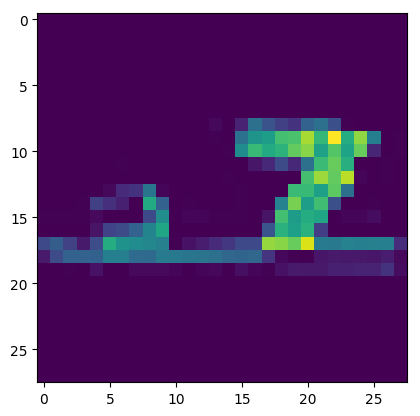

In [2]:
label_name = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
%matplotlib inline
# 可以将matplotlib的图表直接嵌入到Notebook之中，或者使用指定的界面库显示图表
from matplotlib import pyplot as plt

plt.imshow(X_train[0].reshape(28,28))

## 2. Exploratory Data Analysis (5 points)

Your may have to explore the dataset and do some analysis first.

训练集数据类型： uint8
训练集中元素最大值/最小值： 255 / 0
训练集中元素平均值： 72.80150457785854
训练集中元素标准差 89.89044457389586
训练集中各类别条目数量:
 [6000, 4000, 1000, 1000, 1000, 1000, 200, 200, 100, 100]
观察可知存在类别不均衡的问题

观察可知数据分布不均匀，而且0较多，且值的差异较大，从0-255不等



/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


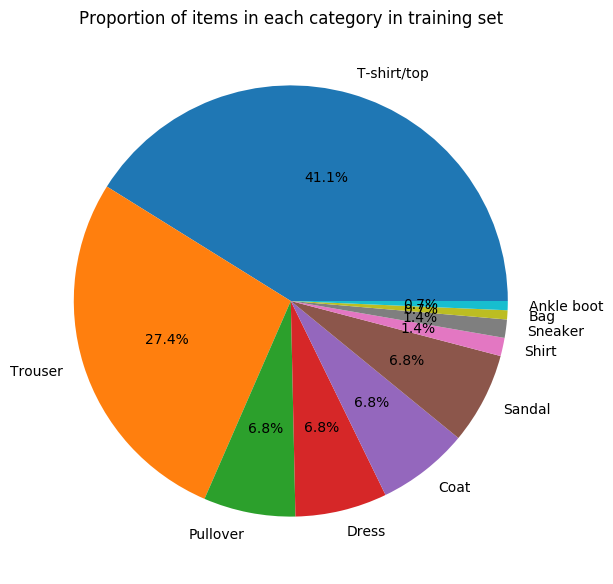

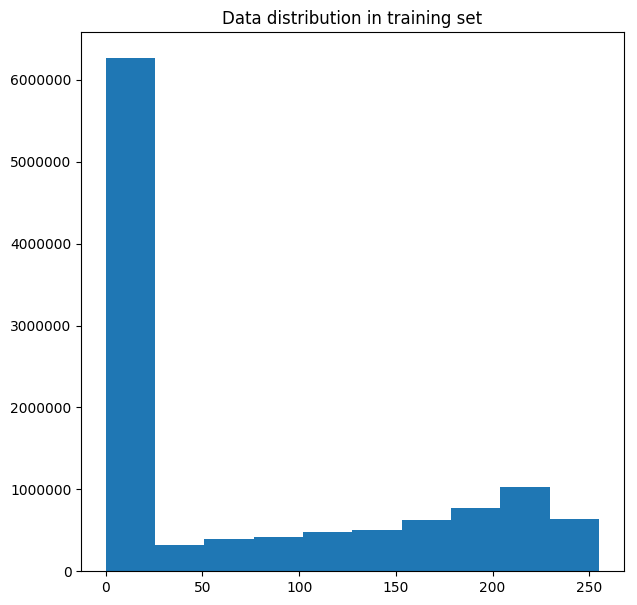

In [3]:
import matplotlib
matplotlib.rcParams['font.family']='SimHei'

print('训练集数据类型：',X_train.dtype)
print('训练集中元素最大值/最小值：',np.max(X_train),'/',np.min(X_train))
print('训练集中元素平均值：',np.mean(X_train))
print('训练集中元素标准差',np.std(X_train))
label_summary = [0 for i in range(10)]
for label in y_train:
    label_summary[label] = label_summary[label] + 1
print('训练集中各类别条目数量:\n',label_summary)
plt.figure(figsize=(7,7))
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  #指定字体为雅黑，解决文字乱码问题
plt.title('Proportion of items in each category in training set')
plt.pie(label_summary,labels=label_name,autopct="%1.1f%%")
plt.show()
print('观察可知存在类别不均衡的问题\n')
plt.figure(figsize=(7,7))
X_train_list = X_train.reshape(-1)
plt.title('Data distribution in training set')
plt.hist(X_train_list)
plt.show()
print('观察可知数据分布不均匀，而且0较多，且值的差异较大，从0-255不等\n')

## 3. Methodology

### 3.1 K-nearest Neighbor (15 points)

#### 实例化KNN分类器

In [4]:
from fudanPRML.neighbors.k_nearest_neighbor import KNearestNeighbor
clf = KNearestNeighbor()
clf.fit(X_train, y_train)
dists = clf.compute_distances_no_loops(X_test)
print(dists.shape)

(10000, 14600)


#### 进行5折交叉验证选择最优超参数k的值

In [5]:
num_folds = 5
k_choices = [1, 3, 4, 5,6,7, 8]

X_train_folds = []
y_train_folds = []
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
k_to_accuracies = {}
for k in k_choices:
    acc = []
    for i in range(num_folds):
        X_val_train = np.vstack(X_train_folds[0:i] + X_train_folds[i+1:])
        y_val_train = np.hstack(y_train_folds[0:i] + y_train_folds[i+1:])
        clf.fit(X_val_train,y_val_train)
        y_pred = clf.predict(X_train_folds[i], k)
        num_correct = np.sum(y_pred == y_train_folds[i])
        accuracy = float(num_correct) / len(y_train_folds[i])
        acc.append(accuracy)
        k_to_accuracies[k] = acc


# 打印出计算的精度
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy),end = '\t')
    print()
    


k = 1, accuracy = 0.903767	k = 1, accuracy = 0.904110	k = 1, accuracy = 0.902397	k = 1, accuracy = 0.908562	k = 1, accuracy = 0.901027	
k = 3, accuracy = 0.905822	k = 3, accuracy = 0.912671	k = 3, accuracy = 0.909589	k = 3, accuracy = 0.915411	k = 3, accuracy = 0.909589	
k = 4, accuracy = 0.903082	k = 4, accuracy = 0.912329	k = 4, accuracy = 0.914726	k = 4, accuracy = 0.918493	k = 4, accuracy = 0.909247	
k = 5, accuracy = 0.907534	k = 5, accuracy = 0.912671	k = 5, accuracy = 0.911644	k = 5, accuracy = 0.919178	k = 5, accuracy = 0.910616	
k = 6, accuracy = 0.906164	k = 6, accuracy = 0.913014	k = 6, accuracy = 0.916781	k = 6, accuracy = 0.917808	k = 6, accuracy = 0.907877	
k = 7, accuracy = 0.902397	k = 7, accuracy = 0.910959	k = 7, accuracy = 0.916781	k = 7, accuracy = 0.917123	k = 7, accuracy = 0.908562	
k = 8, accuracy = 0.904795	k = 8, accuracy = 0.913014	k = 8, accuracy = 0.914041	k = 8, accuracy = 0.915411	k = 8, accuracy = 0.906164	


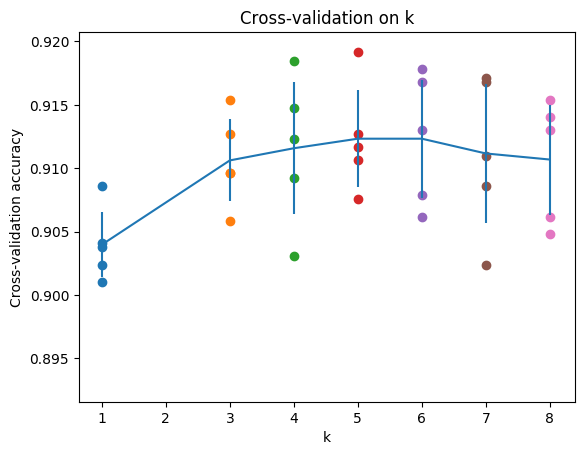

In [6]:
# 绘制原始观察结果
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# 用与标准偏差相对应的误差线绘制趋势线
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

#### 选择最佳k值，使用全部训练数据训练分类器并测试

已经可以达到78.07%的正确率

In [7]:
# 根据上述交叉验证结果，为k选择最佳值，使用所有训练数据重新训练分类器，
# 并在测试中对其进行测试数据。
best_k = k_choices[accuracies_mean.argmax()]
print('best_k = ',best_k)
clf = KNearestNeighbor()
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test_pred)
print('Got %d / %d correct => accuracy: %f' % (num_correct, len(y_test_pred), accuracy))

best_k =  5
Got 7807 / 10000 correct => accuracy: 0.780700


### 3.2 Softmax (15 points)

#### 3.2.1 处理数据集，从训练集再次划分出验证集，用于最优模型保存

In [8]:
# 验证集比例
valid_rate = 0.3

data_num = X_train.shape[0]
train_num = int(data_num*(1 - valid_rate))

# 训练数据类型是uint8，但是paddle居然不支持! 这里分别转为float32和int32
X_train_set = paddle.to_tensor(X_train[:train_num],dtype='float32') 
X_valid_set = paddle.to_tensor(X_train[train_num:],dtype='float32')
y_train_set = paddle.to_tensor(y_train[:train_num],dtype='int32')   
y_valid_set = paddle.to_tensor(y_train[train_num:],dtype='int32')
X_test_set = paddle.to_tensor(X_test,dtype = 'float32')
y_test_set = paddle.to_tensor(y_test,dtype = 'int32')

#### 3.2.2 定义模型、损失函数、优化器、评价指标、绘图函数、封装好的用于训练测试的Runner类

In [9]:
from fudanPRML.linear_model.softmax import SoftmaxClassifier
from fudanPRML.linear_model.criterion import MultiCrossEntropyLoss
from fudanPRML.linear_model.optimizer import SimpleBatchGD
from fudanPRML.linear_model.metric import accuracy
from fudanPRML.linear_model.plot import plot
from fudanPRML.linear_model.runner import RunnerV2

#### 3.2.3 设置参数，实例化模型

In [10]:
init_lr = 0.01
num_epochs = 1000
log_epochs = 10

model = SoftmaxClassifier(input_dim = 784 ,output_dim = 10)
metric = accuracy
criterion = MultiCrossEntropyLoss()
optimizer = SimpleBatchGD(init_lr=init_lr,model=model)
# 实例化RunnerV2
runner = RunnerV2(model, optimizer, metric, criterion)

#### 3.2.4 启动训练

In [ ]:
runner.train([X_train_set, y_train_set], [X_valid_set, y_valid_set], num_epochs = num_epochs, log_epochs = log_epochs, save_path="best_model.pdparams")

#### 3.2.6 绘制图像

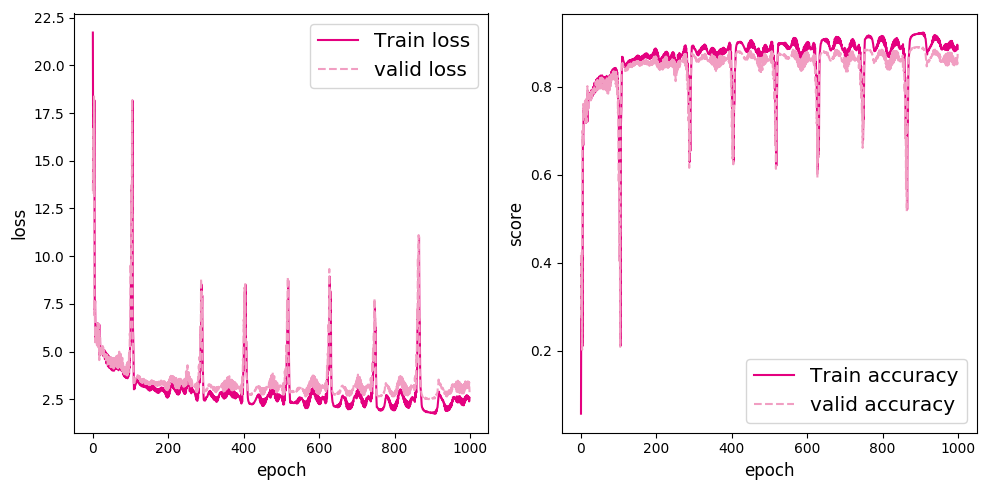

In [12]:
# 绘制训练过程中loss下降图像

plot(runner,fig_name='softmax_classifier.pdf')

#### 3.2.7 在测试集上评估模型

可知softmax线性回归分类器达到了70.8%的正确率

In [13]:
# 使用测试集评估模型

# 加载最优模型
runner.load_model('best_model.pdparams')
# 模型评价
score, loss = runner.evaluate([X_test_set, y_test_set])
print(f'[Test Dataset]: accuracy:{score}, loss: {loss}')

[Test Dataset]: accuracy:0.7083998918533325, loss: 6.690972328186035


#### 3.2.8 一些感受与分析


##### 关于使用验证集的问题：

类别不均衡问题仍然影响很大，在测试集上效果不算太好，使用验证集保存最优参数的方法，事实上也逐渐使得模型拟合在了验证集上

然而，我们应该注意到，本身测试集类别不均衡，验证集中更可能出现某些类别数量极其小的情况，因此反而效果更差。

##### 关于优化器和梯度下降过程：

一开始使用了lr = 0.1 的整批常规梯度下降方法，在训练到接近100轮epoch时，loss出现激增。分析原因，应该是在训练后期学习率过大所致，后续可以采用学习率衰减或者动量的方法

### 3.3 Neural Network (30 points)

#### 3.3.1 数据集构建
直接使用 3.2.1 中划分好的数据集，在此不再重复

In [14]:
# 验证集比例
valid_rate = 0.3

data_num = X_train.shape[0]
train_num = int(data_num*(1 - valid_rate))

# 训练数据类型是uint8，但是paddle居然不支持! 这里分别转为float32和int32
X_train_set = paddle.to_tensor(X_train[:train_num],dtype='float32') 
X_valid_set = paddle.to_tensor(X_train[train_num:],dtype='float32')
y_train_set = paddle.to_tensor(y_train[:train_num],dtype='int32')   
y_valid_set = paddle.to_tensor(y_train[train_num:],dtype='int32')
X_test_set = paddle.to_tensor(X_test,dtype = 'float32')
y_test_set = paddle.to_tensor(y_test,dtype = 'int32')

#### 3.3.2 定义模型、损失函数、优化器、评价指标、以及封装好的Runner类

In [15]:
from fudanPRML.neural_network.mlp import Model_MLP_L2
from fudanPRML.neural_network.CrossEntropy import MultiCrossEntropyLoss
from fudanPRML.neural_network.optimizer import BatchGD
from fudanPRML.neural_network.metric import accuracy
from fudanPRML.neural_network.runner import RunnerV2_1

#### 3.3.3 开始训练

In [16]:
epoch_num = 1000

model_saved_dir = "model"

# 输入层维度为2
input_size = 784
# 隐藏层维度为5
hidden_size = 256
# 输出层维度为1
output_size = 10

# 定义网络
model = Model_MLP_L2(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# 损失函数
loss_fn = MultiCrossEntropyLoss(model = model)

# 优化器
learning_rate = 0.1
optimizer = BatchGD(learning_rate, model)

# 评价方法
metric = accuracy

# 实例化RunnerV2_1类，并传入训练配置
runner = RunnerV2_1(model, optimizer, metric, loss_fn)

runner.train([X_train_set, y_train_set], [X_valid_set, y_valid_set], num_epochs=epoch_num, log_epochs=1, save_dir=model_saved_dir)

#### 3.3.4 绘制图像

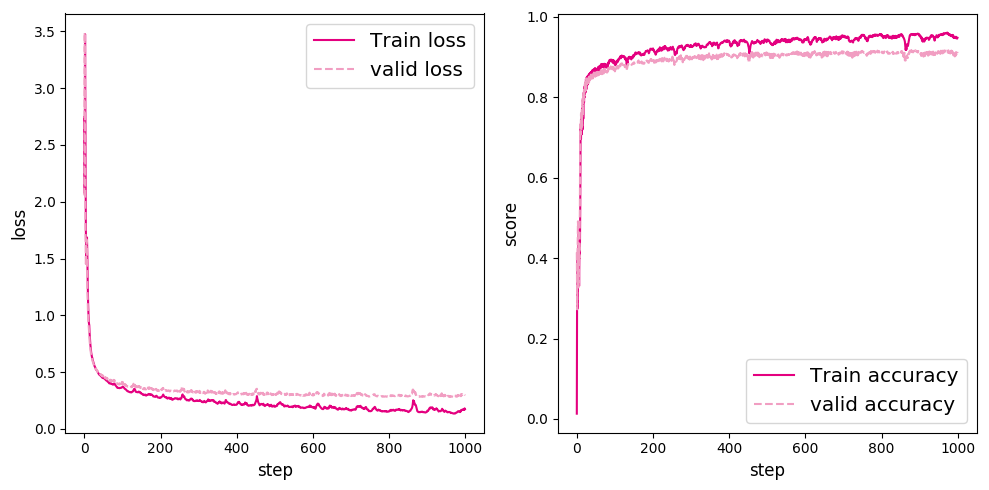

In [19]:
# 打印训练集和验证集的损失 
from fudanPRML.neural_network.plot import plot
plot(runner,fig_name='nnfigure')

#### 3.3.5 在测试集上评估模型

可以看到，同样经过1000轮训练，两层前馈神经网络在测试集上准确率更高了，达到了74.3%，超过了单层softmax分类器的70.8%。

由于两层MLP参数更多，网络更深，能力更强，此结果是合理的。但是仍然不及KNN的78%

我们在探索部分进行进一步分析

In [20]:
# 加载训练好的模型
runner.load_model(model_saved_dir)
# 在测试集上对模型进行评价
score, loss = runner.evaluate([X_test_set, y_test_set])

print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.7430/0.8094


### 3.4 Your Exploration (30 points)

之前结果：
1. KNN 78.1%
2. softmax 70.8%
3. 两层MLP(隐藏层维度256) 74.3%

为了得到更好的结果，我们进一步探索

#### 3.4.0 Xavier及Kaiming He 参数初始化

众所周知，参数的初始化像投胎一样。

众所周知，投胎的好坏比后天的努力重要的多。

因此在这里采用了两种初始化方式，Xavier初始化对应着sigmoid等饱和型激活函数，Kaiming He初始化对应着ReLU激活函数。

膜拜一下何凯明大神，目前主流默认激活函数都是ReLU，而Pytorch对Linear层的默认初始化方式就是Kaiming He初始化。因此，我们采用这种初始化方式。

能够有效避免ReLU死亡或饱和函数的梯度消失问题

In [21]:
# 具体实现在这里
from fudanPRML.neural_network.Layer.Linear import Linear
'''
我的具体实现代码
if act_fn == Logistic:
            # 即为Logistic 使用Xavier初始化
            self.params['W'] = paddle.normal(mean=0, std= np.sqrt(1/input_size), shape=[input_size, output_size])
            self.params['b'] = bias_init(shape=[1, output_size])
        else:
            # 即为ReLU 使用 Kaiming He 初始化
            self.params['W'] = paddle.normal(mean=0, std= np.sqrt(2/input_size), shape=[input_size, output_size])
            self.params['b'] = bias_init(shape=[1, output_size]) + 0.01
'''

"\n我的具体实现代码\nif act_fn == Logistic:\n            # 即为Logistic 使用Xavier初始化\n            self.params['W'] = paddle.normal(mean=0, std= np.sqrt(1/input_size), shape=[input_size, output_size])\n            self.params['b'] = bias_init(shape=[1, output_size])\n        else:\n            # 即为ReLU 使用 Kaiming He 初始化\n            self.params['W'] = paddle.normal(mean=0, std= np.sqrt(2/input_size), shape=[input_size, output_size])\n            self.params['b'] = bias_init(shape=[1, output_size]) + 0.01\n"

#### 3.4.1 Normalization (归一化) & Standardization(标准化)

事实上我没有一开始就想到这个事情，属于是忘掉了。这是我做了后面一些探索之后发现不对劲才想起这个问题。

但是后面发现了两个问题：

1、就算采用了过采样，仍然得不到特别好的结果

2、我使用现在最流行的ReLU激活函数替换了之前的sigmoid(Logistic)激活函数，但发生梯度爆炸，接着来一次极其异常的参数更新，整个神经网络基本死亡，正确率预测基本固定在0.1，loss稳定在2.302（这是因为，神经网络就在瞎猜，10个类别瞎猜每十个数据猜中一个，loss就会是2.302这个可怕的数据）

为了解决这个问题我原来还怀疑是Linear层初始化的问题，故还去搜索资料，使用了Kaming He的初始化方法，仍然不见效果。

直到最后，回看以前在MNIST数据集上做的实验，才发现，人家先有一个整体的Normalization的过程！而且发现自己的ReLU层的反向传播写错了！寄！

先给整体数据做一下Normalization:
$$
x = x / 255
$$

再使用了Standardization方法（Z-score）, 转换后分布的参数可能会变，但分布类型不会改变，更不一定就是正态分布(误区)

$$

x = \frac{x - x_{mean}}{std}

$$

这种方法被广泛应用于对图像的处理中，其优点主要是一般可以收敛更快，且受初始化参数的影响会小一些

一般这种情况下，就不需要训练那么多轮，需要较少的轮次，loss就会在训练集上收敛

但这只是对训练过程的优化，对于过拟合，以及样本类别不均衡等问题（导致验证集也类别不均衡！），并没有什么帮助！因此并不会对测试集结果有多少改善。

对于MNISI数据集，tensotflow的官方演示就是先做了归一化，再做标准化，因此对于同样是0-255灰度的FashionMNIST，我认为两个操作都做一下是有必要的

In [22]:
import numpy as np
X_train = X_train/255
X_test = X_test/255
mean_train = np.mean(X_train)
std_train = np.std(X_train)
mean_test = np.mean(X_test)
std_test = np.std(X_test)
X_train = (X_train-mean_train)/std_train
X_test = (X_test - mean_test)/std_test



# 验证集比例
valid_rate = 0.3

data_num = X_train.shape[0]
train_num = int(data_num*(1 - valid_rate))

# 训练数据类型是uint8，但是paddle居然不支持! 这里分别转为float32和int32
X_train_set = paddle.to_tensor(X_train[:train_num],dtype='float32') 
X_valid_set = paddle.to_tensor(X_train[train_num:],dtype='float32')
y_train_set = paddle.to_tensor(y_train[:train_num],dtype='int32')   
y_valid_set = paddle.to_tensor(y_train[train_num:],dtype='int32')
X_test_set = paddle.to_tensor(X_test,dtype = 'float32')
y_test_set = paddle.to_tensor(y_test,dtype = 'int32')

##### 我们先使用KNN测试一下效果
归一化的处理方式对于KNN这种距离类的学习方法往往效果会好些，但结果上其实还是78.1% 目前是比较稳定的

In [27]:
from fudanPRML.neighbors.k_nearest_neighbor import KNearestNeighbor
clf = KNearestNeighbor()
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test_pred)
print('Got %d / %d correct => accuracy: %f' % (num_correct, len(y_test_pred), accuracy))

Got 7805 / 10000 correct => accuracy: 0.780500


##### 我们用MLP_L2 来测试一下效果

In [29]:
from fudanPRML.neural_network.plot import plot
from fudanPRML.neural_network.mlp import Model_MLP_L2
from fudanPRML.neural_network.CrossEntropy import MultiCrossEntropyLoss
from fudanPRML.neural_network.optimizer import BatchGD
from fudanPRML.neural_network.metric import accuracy
from fudanPRML.neural_network.runner import RunnerV2_1,RunnerV3

epoch_num = 1000

model_saved_dir = "model"

# 输入层维度为2
input_size = 784
# 隐藏层维度为5
hidden_size = 256
# 输出层维度为1
output_size = 10

# 定义网络
model = Model_MLP_L2(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# 这是一个5层神经网络
# model = Model_MLP_L5(input_size=input_size,output_size=output_size)

# 损失函数
loss_fn = MultiCrossEntropyLoss(model = model)

# 优化器
learning_rate = 0.01
optimizer = BatchGD(learning_rate, model)

# 评价方法
metric = accuracy

# 实例化RunnerV2_1类，并传入训练配置
runner = RunnerV2_1(model, optimizer, metric, loss_fn)

runner.train([X_train_set,y_train_set], [X_valid_set, y_valid_set], num_epochs=epoch_num, log_epochs=1, save_dir=model_saved_dir)


##### 同样训练1000次，貌似结果并不是很好？
其实观察训练图像可以发现，图像规范化处理后，1000轮训练并没有让损失函数收敛！其实还是可以继续进行训练！因此在测试集上才只有47%的准确率。

我们就先不训练了，保持这一结果用于后续的对比，进一步优化一下训练的过程！

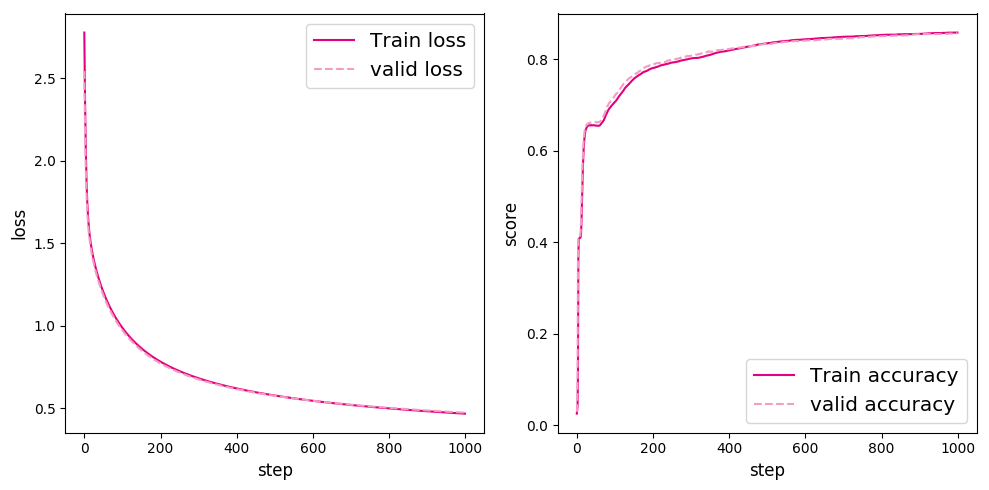

[Test] score/loss: 0.4780/1.4819


In [30]:
plot(runner,fig_name='nnfigure')
# 加载训练好的模型
runner.load_model(model_saved_dir)
# 在测试集上对模型进行评价
score, loss = runner.evaluate([X_test_set, y_test_set])

print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

#### 3.4.2 小批量随机梯度下降法

这种方法同样是用于优化训练的，对于过拟合和类别不均衡，以及最终结果，并没有很大作用。

然而，使用小批量随机梯度下降法，其在训练过程中带来的改进是极其显著的。往往，又只需更少的epoch就可以使得loss快速收敛！

随机小批度带来的噪声，往往能够使loss更快的下降，而不是在以全训练集为整批求loss和梯度那种如此光滑的函数面上下降。

能够有效避开局部最优和鞍点！

但是这样的方法加入了循环，实际上每轮epoch实际上训练了许多次，每个epoch的速度是变慢了许多。

但往往需要更少的epoch就可以使loss迅速收敛。

这个本身不是很难，我们就直接使用paddle提供的dataset，dataloader直接实现

同时重新写了一个应用于小批度随机梯度下降的RunnerV3类封装训练过程

同样在MLP_L2上试验一下

之前epoch都取为1000，从现在开始取为100就好！


In [31]:
import paddle.io as io

class Dataset(io.Dataset):
    def __init__(self,X,y):
        super(Dataset,self).__init__()
        self.X = X
        self.y = y
        self.len = self.y.shape[0]
    def __getitem__(self, idx):
        return self.X[idx],self.y[idx]
    def __len__(self):
        return self.len

In [32]:
from fudanPRML.neural_network.plot import plot
from fudanPRML.neural_network.mlp import Model_MLP_L2
from fudanPRML.neural_network.CrossEntropy import MultiCrossEntropyLoss
from fudanPRML.neural_network.optimizer import BatchGD
from fudanPRML.neural_network.metric import accuracy
from fudanPRML.neural_network.runner import RunnerV3
from fudanPRML.neural_network.Layer.ReLU import ReLU


batch_size = 64

train_dataset = Dataset(X_train_set,y_train_set)
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
epoch_num = 100

model_saved_dir = "model"

# 输入层维度为2
input_size = 784
# 隐藏层维度为5
hidden_size = 256
# 输出层维度为1
output_size = 10

# 定义网络
model = Model_MLP_L2(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# 损失函数
loss_fn = MultiCrossEntropyLoss(model = model)

# 优化器
learning_rate = 0.01
optimizer = BatchGD(learning_rate, model)

# 评价方法
metric = accuracy

# 实例化RunnerV2_1类，并传入训练配置
runner = RunnerV3(model, optimizer, metric, loss_fn)

runner.train(train_loader, [X_valid_set, y_valid_set], num_epochs=epoch_num, log_epochs=1, save_dir=model_saved_dir)


[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.38402
[Evaluate] best accuracy performence has been updated: 0.38402 --> 0.41416
[Evaluate] best accuracy performence has been updated: 0.41416 --> 0.41461
[Evaluate] best accuracy performence has been updated: 0.41461 --> 0.41530
[Evaluate] best accuracy performence has been updated: 0.41530 --> 0.43950
[Evaluate] best accuracy performence has been updated: 0.43950 --> 0.44795
[Evaluate] best accuracy performence has been updated: 0.44795 --> 0.46621
[Evaluate] best accuracy performence has been updated: 0.46621 --> 0.55822
[Evaluate] best accuracy performence has been updated: 0.55822 --> 0.62169
[Evaluate] best accuracy performence has been updated: 0.62169 --> 0.64178
[Evaluate] best accuracy performence has been updated: 0.64178 --> 0.64521
[Evaluate] best accuracy performence has been updated: 0.64521 --> 0.64772
[Evaluate] best accuracy performence has been updated: 0.64772 --> 0.64817
[Evaluate] best accuracy 

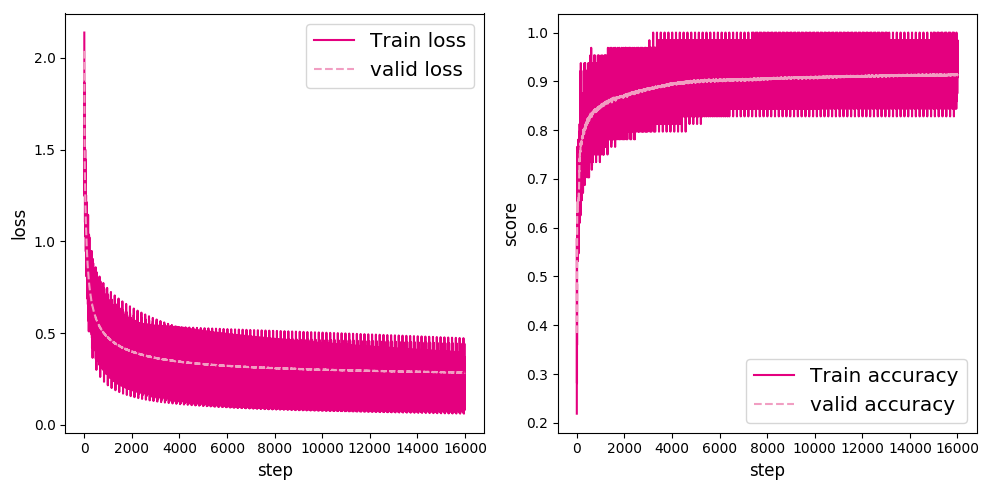

[Test] score/loss: 0.7483/0.7681


In [33]:
plot(runner,fig_name='nnfigure')
# 加载训练好的模型
runner.load_model(model_saved_dir)
# 在测试集上对模型进行评价
score, loss = runner.evaluate([X_test_set, y_test_set])

print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

##### 分析
可以看到，这样使用MLP_L2就比刚才直接训练1000轮效果好的多，准确率从不到50%提升到了74.8%。这也比之前不做图像规范化的准确率有所提升！

从74.3%提升到了74.8%!

因为小批量随机梯度下降带来的损失函数是“有噪音”的，并不是全局的那个光滑的损失函数，这样好处是能有效避开鞍点和局部最优，缺点是后期因为步长过长和大噪音的原因loss function会有剧烈震荡

#### 3.4.3 使用带有Momentum（动量）的优化器

momentum, 前期可以加速，后期可以提高迭代的稳定性，也有助于避开鞍点和局部最优

我自己实现于 fudanPRML.neural_network.optimizer 的 SGD 中

明显获得了更好的效果，更快的收敛速度！

可以看到其“稳定器”的作用，loss后期震荡幅度越来越小了！

使用这种优化器带来的提升是惊人的！

我们可以看到直接将两层MLP的准确率由74.8% 提升到了 80.7%！这已经打败了KNN了！

In [ ]:
'''
我在 SGD 中实现的带有 动量 的优化器的代码
def __init__(self, init_lr, model, rho = 0.9):
        super(SGD, self).__init__(init_lr=init_lr, model=model)
        self.rho = rho
    def step(self):
        # 参数更新
        for layer in self.model.layers: # 遍历所有层
            if isinstance(layer.params, dict):
                for key in layer.params.keys():
                    layer.momentum[key] = self.rho * layer.momentum[key] - self.init_lr * layer.grads[key]
                    layer.params[key] = layer.params[key] + layer.momentum[key]
'''

In [34]:
from fudanPRML.neural_network.plot import plot
from fudanPRML.neural_network.mlp import Model_MLP_L2
from fudanPRML.neural_network.CrossEntropy import MultiCrossEntropyLoss
from fudanPRML.neural_network.optimizer import SGD
from fudanPRML.neural_network.metric import accuracy
from fudanPRML.neural_network.runner import RunnerV2_1,RunnerV3
from fudanPRML.neural_network.Layer.ReLU import ReLU

batch_size = 64

train_dataset = Dataset(X_train_set,y_train_set)
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
epoch_num = 100

model_saved_dir = "model"

# 输入层维度为2
input_size = 784
# 隐藏层维度为5
hidden_size = 256
# 输出层维度为1
output_size = 10

# 定义网络
model = Model_MLP_L2(input_size=input_size, hidden_size=hidden_size, output_size=output_size)


# 损失函数
loss_fn = MultiCrossEntropyLoss(model = model)

# 优化器
learning_rate = 0.01
optimizer = SGD(learning_rate, model,rho=0.9)

# 评价方法
metric = accuracy

# 实例化RunnerV2_1类，并传入训练配置
runner = RunnerV3(model, optimizer, metric, loss_fn)

runner.train(train_loader, [X_valid_set, y_valid_set], num_epochs=epoch_num, log_epochs=1, save_dir=model_saved_dir)


[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.01804
[Evaluate] best accuracy performence has been updated: 0.01804 --> 0.33014
[Evaluate] best accuracy performence has been updated: 0.33014 --> 0.44429
[Evaluate] best accuracy performence has been updated: 0.44429 --> 0.59909
[Evaluate] best accuracy performence has been updated: 0.59909 --> 0.62694
[Evaluate] best accuracy performence has been updated: 0.62694 --> 0.63973
[Evaluate] best accuracy performence has been updated: 0.63973 --> 0.71941
[Evaluate] best accuracy performence has been updated: 0.71941 --> 0.75616
[Evaluate] best accuracy performence has been updated: 0.75616 --> 0.75959
[Evaluate] best accuracy performence has been updated: 0.75959 --> 0.76187
[Evaluate] best accuracy performence has been updated: 0.76187 --> 0.76667
[Evaluate] best accuracy performence has been updated: 0.76667 --> 0.77009
[Evaluate] best accuracy performence has been updated: 0.77009 --> 0.77466
[Evaluate] best accuracy 

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


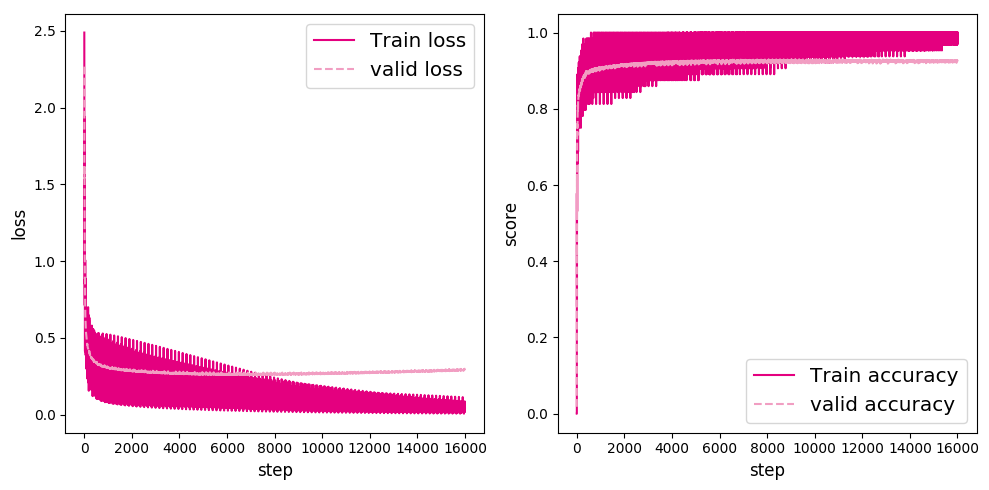

[Test] score/loss: 0.8068/0.6709


In [35]:
plot(runner,fig_name='nnfigure')
# 加载训练好的模型
runner.load_model(model_saved_dir)
# 在测试集上对模型进行评价
score, loss = runner.evaluate([X_test_set, y_test_set])

print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

#### 3.4.4 更多层的前馈神经网络架构
本任务中默认要求完成一个MLP_L2，即一个两层的前馈神经网络。

而一般来说，在达到同样的测试效果时，深层网络会比浅层网络需要更少的参数量。

因此，我定义了一个5层的前馈神经网络，其架构为：

(784,512),(512,256),(256,128),(128,64),(64,10)

使用此网络，我曾经在MNIST手写数字识别数据集上训练，可以达到95%的准确率，因此在此网络中同样进行尝试。

后续的探索，有时会使用这个MLP_L5的架构

然而，这个网络虽然能力远远比两层MLP强，但是参数也远远超过两层MLP，因此需要更多的训练轮次才可以达到收敛！

事实上可以发现，有时候网络结构不是影响结果的问题，问题是训练数据的不一致性。即使后续通过算法解决类别不均衡问题，也很难与测试数据达到同一分布

In [26]:
# 5层MLP实现于此文件中
from fudanPRML.neural_network.mlp import Model_MLP_L5

#### 3.4.5 解决类别不均衡问题
类别不均衡的问题会对数据训练过程产生很大影响，在多分类问题中又称为“长尾”问题，进行预测类别时，分类器将有预测训练数据中数量最多的类别的趋势，这可以在训练中达到极高的准确率。

然而，我们往往关心的是分类器在测试数据集中，对任何一类数据预测的表现，即使它的数量很少

最常见的方法，是对数据集直接进行处理，这其中，一般有 过采样(重采样)，欠采样 两种方法，因采样存在丢弃训练数据的情况，容易造成欠拟合，因此又以过采样应用为多。

常用方法有SMOTE，ADASYN，SMOTE_borderline等等

我们使用了imbalanced-learn库帮助完成这个任务

使用pip install -U imbalanced-learn

或者 conda install imbalanced-learn 安装

使用conda安装需要先添加一个国内的对condaforge的镜像源，在paddle平台上我建议直接使用pip安装就好了


##### 3.4.2.1 ROS 简单随机过采样 (Naive random over-sampling)
 The most naive strategy is to generate new samples by randomly sampling with replacement the current available samples.

 这种方法极其容易造成过拟合，我们不过多实验，仅仅在KNN上试验一下效果

##### 进行ROS过采样及数据处理

In [36]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
ros = RandomOverSampler(random_state=0)
X_train_resampled,y_train_resampled = ros.fit_resample(X_train,y_train)

##### ROS + KNN

可以看到，虽然就是简单的重复采样，但是KNN的效果已经比之前有了很大提升！

测试集上直接由78.1% 提升到了 80.1% ！ （虽然还是没有超过MLP） 

In [37]:
from fudanPRML.neighbors.k_nearest_neighbor import KNearestNeighbor
clf = KNearestNeighbor()
clf.fit(X_train_resampled, y_train_resampled)
y_test_pred = clf.predict(X_test, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test_pred)
print('Got %d / %d correct => accuracy: %f' % (num_correct, len(y_test_pred), accuracy))


Got 8008 / 10000 correct => accuracy: 0.800800


#####  SMOTE算法
SMOTE是基于KNN的一种随机插值算法，其原理也比较简单，但它不再是简单的重复采样，而是使用了在基于KNN的临近点之间，进行随机插值的方法

##### SMOTE过采样及数据处理

In [38]:
from imblearn.over_sampling import SMOTE
from collections import Counter
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
print('当前各类别数量',sorted(Counter(y_train_resampled).items()))

# 此处必须重新打乱！过采样采集的数据不是很均匀！
idx = paddle.randperm(X_train_resampled.shape[0])
X_train_resampled = X_train_resampled[idx]
y_train_resampled = y_train_resampled[idx]

# 验证集比例
valid_rate = 0.2
data_num = X_train_resampled.shape[0]
train_num = int(data_num*(1 - valid_rate))

# 训练数据类型是uint8，但是paddle居然不支持! 这里分别转为float32和int32
X_train_set = paddle.to_tensor(X_train_resampled[:train_num],dtype='float32') 
X_valid_set = paddle.to_tensor(X_train_resampled[train_num:],dtype='float32')
y_train_set = paddle.to_tensor(y_train_resampled[:train_num],dtype='int32')   
y_valid_set = paddle.to_tensor(y_train_resampled[train_num:],dtype='int32')
X_test_set = paddle.to_tensor(X_test,dtype = 'float32')
y_test_set = paddle.to_tensor(y_test,dtype = 'int32')

当前各类别数量 [(0, 6000), (1, 6000), (2, 6000), (3, 6000), (4, 6000), (5, 6000), (6, 6000), (7, 6000), (8, 6000), (9, 6000)]


##### SMOTE + KNN
可以看到，使用SMOTE后，KNN的效果比ROS的重复采样，明显又有了显著进步！

80.1% -> 82.15% !

那我们本次实验KNN就进行到这这里，KNN的最好结果就是82.15%了

In [39]:
from fudanPRML.neighbors.k_nearest_neighbor import KNearestNeighbor
clf = KNearestNeighbor()
clf.fit(X_train_resampled, y_train_resampled)
y_test_pred = clf.predict(X_test, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / len(y_test_pred)
print('Got %d / %d correct => accuracy: %f' % (num_correct, len(y_test_pred), accuracy))

Got 8215 / 10000 correct => accuracy: 0.821500


##### SMOTE + MLP_L2
可以看到，与不进行重采样相比，两层MLP使用SMOTE过采样后，在测试集上正确率同样得到了明显提升！

80.7 % -> 82.1%！

[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.09383
[Evaluate] best accuracy performence has been updated: 0.09383 --> 0.10208
[Evaluate] best accuracy performence has been updated: 0.10208 --> 0.19092
[Evaluate] best accuracy performence has been updated: 0.19092 --> 0.23042
[Evaluate] best accuracy performence has been updated: 0.23042 --> 0.26083
[Evaluate] best accuracy performence has been updated: 0.26083 --> 0.29108
[Evaluate] best accuracy performence has been updated: 0.29108 --> 0.33100
[Evaluate] best accuracy performence has been updated: 0.33100 --> 0.36358
[Evaluate] best accuracy performence has been updated: 0.36358 --> 0.39375
[Evaluate] best accuracy performence has been updated: 0.39375 --> 0.42425
[Evaluate] best accuracy performence has been updated: 0.42425 --> 0.43175
[Evaluate] best accuracy performence has been updated: 0.43175 --> 0.43725
[Evaluate] best accuracy performence has been updated: 0.43725 --> 0.44933
[Evaluate] best accuracy 

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


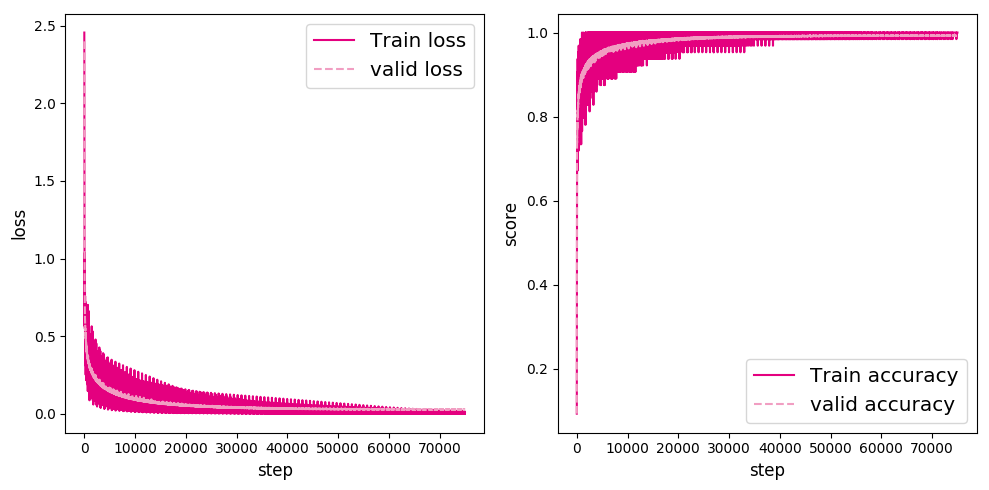

[Test] score/loss: 0.8207/1.0901


In [40]:
from fudanPRML.neural_network.plot import plot
from fudanPRML.neural_network.mlp import Model_MLP_L2
from fudanPRML.neural_network.CrossEntropy import MultiCrossEntropyLoss
from fudanPRML.neural_network.optimizer import SGD
from fudanPRML.neural_network.metric import accuracy
from fudanPRML.neural_network.runner import RunnerV3


batch_size = 64

train_dataset = Dataset(X_train_set,y_train_set)
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

epoch_num = 100

model_saved_dir = "model"

# 输入层维度为2
input_size = 784
# 隐藏层维度为5
hidden_size = 256
# 输出层维度为1
output_size = 10

# 定义网络
model = Model_MLP_L2(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# 损失函数
loss_fn = MultiCrossEntropyLoss(model = model)

# 优化器
learning_rate = 0.01
optimizer = SGD(learning_rate, model,rho=0.9)

# 评价方法
metric = accuracy

# 实例化RunnerV2_1类，并传入训练配置
runner = RunnerV3(model, optimizer, metric, loss_fn)

runner.train(train_loader, [X_valid_set, y_valid_set], num_epochs=epoch_num, log_epochs=1, save_dir=model_saved_dir)
plot(runner,fig_name='nnfigure')
# 加载训练好的模型
runner.load_model(model_saved_dir)
# 在测试集上对模型进行评价
score, loss = runner.evaluate([X_test_set, y_test_set])

print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

#### 3.4.6 不同激活函数的影响
之前默认使用了Logistic激活函数，然而在多层前馈神经网络训练中，可能出现梯度消失的问题，因此不太适用于MLP_L5

接下来将尝试ReLU更广泛使用的激活函数。

ReLU能有效避免梯度消失的问题，然而在学习率过大时，在一次不恰当地参数更新后，很可能出现死亡ReLU问题，直接造成某个神经元地死亡。因此有时引入Leaky_ReLU是有必要的

但是实际应用中，ReLU往往用的更多，甚至是后续的GeLU

我同样自己实现了ReLU层,在 fudanPRML.neural_network.Layer.ReLU 中

In [ ]:
'''
class ReLU(Op):
    def __init__(self):
        self.unmask = None
        self.params = None
         
    def forward(self, X):
        self.unmask = (X > 0)
        self.unmask = self.unmask.cast('float32')
        return paddle.maximum(X, paddle.to_tensor(0.))

    def backward(self, grads):
        return paddle.multiply(grads,self.unmask)
'''

##### SMOTE + ReLU + MLP_L2 + Momentum + SGD

结果也有少量提升，但不是很明显。毕竟网络较浅，而且不是卷积网络。

但观察可以发现，使用ReLU可以在训练集上迅速拟合，居然早早就在训练集上达到了100%的准确率。显然是有过拟合的。

即使在验证集上也有很高准确率，但是测试集和训练集的分布是不一样的。这才是最大问题

准确率仍然在82%左右

[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.13842
[Evaluate] best accuracy performence has been updated: 0.13842 --> 0.32650
[Evaluate] best accuracy performence has been updated: 0.32650 --> 0.48167
[Evaluate] best accuracy performence has been updated: 0.48167 --> 0.50567
[Evaluate] best accuracy performence has been updated: 0.50567 --> 0.52317
[Evaluate] best accuracy performence has been updated: 0.52317 --> 0.56075
[Evaluate] best accuracy performence has been updated: 0.56075 --> 0.63583
[Evaluate] best accuracy performence has been updated: 0.63583 --> 0.67225
[Evaluate] best accuracy performence has been updated: 0.67225 --> 0.68775
[Evaluate] best accuracy performence has been updated: 0.68775 --> 0.70800
[Evaluate] best accuracy performence has been updated: 0.70800 --> 0.72283
[Evaluate] best accuracy performence has been updated: 0.72283 --> 0.75042
[Evaluate] best accuracy performence has been updated: 0.75042 --> 0.75233
[Evaluate] best accuracy 

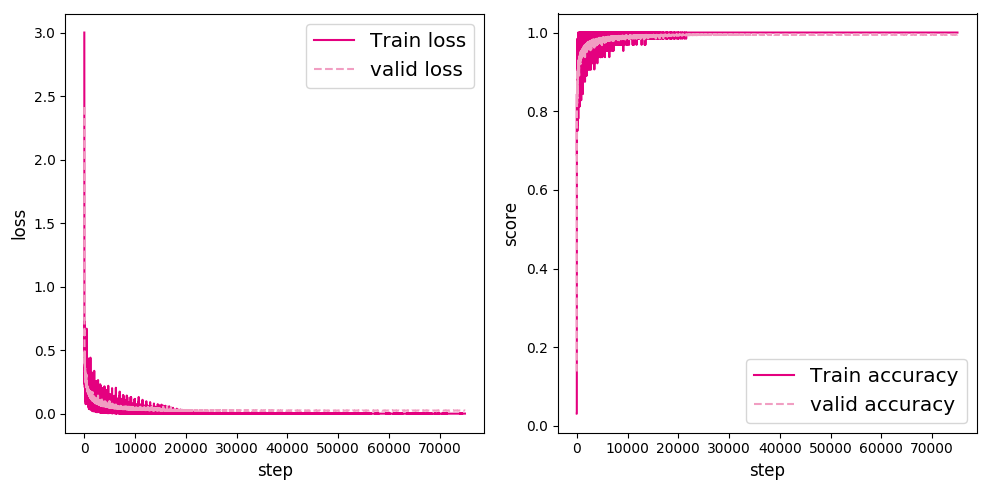

[Test] accuravy/loss: 0.8202/1.4289


In [41]:
from fudanPRML.neural_network.mlp import Model_MLP_L2
from fudanPRML.neural_network.CrossEntropy import MultiCrossEntropyLoss
from fudanPRML.neural_network.optimizer import SGD
from fudanPRML.neural_network.metric import accuracy
from fudanPRML.neural_network.runner import RunnerV3
from fudanPRML.neural_network.plot import plot
from fudanPRML.neural_network.Layer.ReLU import ReLU
from fudanPRML.neural_network.Layer.Logistic import Logistic


batch_size = 64

train_dataset = Dataset(X_train_set,y_train_set)
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

epoch_num = 100

model_saved_dir = "model"

# 输入层维度为2
input_size = 784
# 隐藏层维度为5
hidden_size = 256
# 输出层维度为1
output_size = 10

# 定义网络
model = Model_MLP_L2(input_size=input_size, hidden_size=hidden_size, output_size=output_size,act_fn=ReLU)

# 损失函数
loss_fn = MultiCrossEntropyLoss(model = model)

# 优化器
learning_rate = 0.01
optimizer = SGD(learning_rate, model)

# 评价方法
metric = accuracy

# 实例化RunnerV2_1类，并传入训练配置
runner = RunnerV3(model, optimizer, metric, loss_fn,act_fn = ReLU)

runner.train(train_loader, [X_valid_set, y_valid_set], num_epochs=epoch_num, log_epochs=1, save_dir=model_saved_dir)
# 打印训练集和验证集的损失 
plot(runner,fig_name='nnfigure')
# 加载训练好的模型
runner.load_model(model_saved_dir)
# 在测试集上对模型进行评价
score, loss = runner.evaluate([X_test_set, y_test_set])
print("[Test] accuravy/loss: {:.4f}/{:.4f}".format(score, loss))

##### SMOTE + ReLU + MLP_L5 + Momentum + SGD

其实可以看到五层MLP很快就在训练集上准确率达到100%，后面在验证集上也不会更新。

这比之前使用两层前馈网络的结果又有了提升！

82.1% -> 82.7% 

可见5层MLP有更强的能力

[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.20325
[Evaluate] best accuracy performence has been updated: 0.20325 --> 0.33542
[Evaluate] best accuracy performence has been updated: 0.33542 --> 0.45050
[Evaluate] best accuracy performence has been updated: 0.45050 --> 0.51433
[Evaluate] best accuracy performence has been updated: 0.51433 --> 0.56192
[Evaluate] best accuracy performence has been updated: 0.56192 --> 0.60558
[Evaluate] best accuracy performence has been updated: 0.60558 --> 0.64608
[Evaluate] best accuracy performence has been updated: 0.64608 --> 0.67500
[Evaluate] best accuracy performence has been updated: 0.67500 --> 0.71775
[Evaluate] best accuracy performence has been updated: 0.71775 --> 0.72117
[Evaluate] best accuracy performence has been updated: 0.72117 --> 0.76700
[Evaluate] best accuracy performence has been updated: 0.76700 --> 0.78683
[Evaluate] best accuracy performence has been updated: 0.78683 --> 0.79033
[Evaluate] best accuracy 

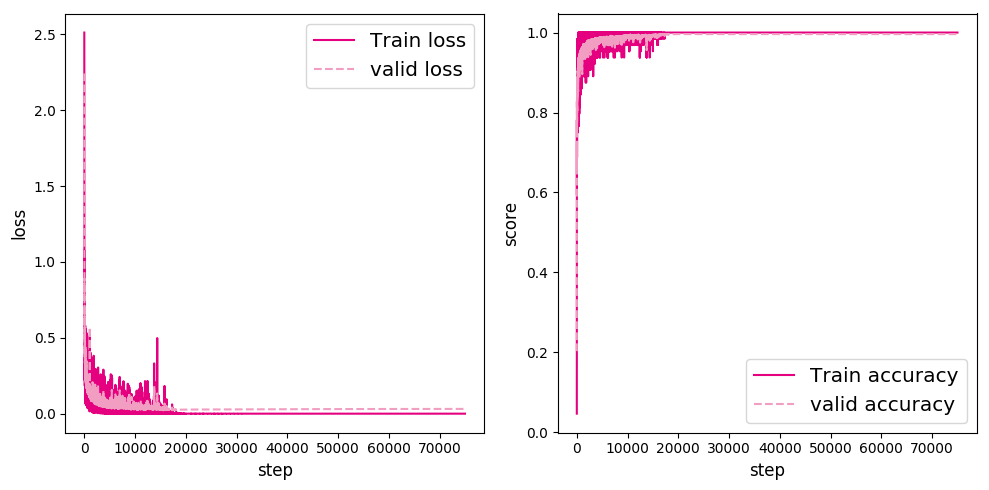

[Test] accuravy/loss: 0.8270/2.1637


In [42]:
from fudanPRML.neural_network.mlp import Model_MLP_L5
from fudanPRML.neural_network.CrossEntropy import MultiCrossEntropyLoss
from fudanPRML.neural_network.optimizer import SGD
from fudanPRML.neural_network.metric import accuracy
from fudanPRML.neural_network.runner import RunnerV3
from fudanPRML.neural_network.plot import plot
from fudanPRML.neural_network.Layer.ReLU import ReLU
from fudanPRML.neural_network.Layer.Logistic import Logistic

epoch_num = 100
batch_size = 64

train_dataset = Dataset(X_train_set,y_train_set)
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

model_saved_dir = "model"

# 输入层维度为2
input_size = 784
# 隐藏层维度为5
hidden_size = 256
# 输出层维度为1
output_size = 10

# 定义网络
model = Model_MLP_L5(input_size=input_size,output_size=output_size,act_fn=ReLU)

# 损失函数
loss_fn = MultiCrossEntropyLoss(model = model)

# 优化器
learning_rate = 0.01
optimizer = SGD(learning_rate, model,rho = 0.9)

# 评价方法
metric = accuracy

# 实例化RunnerV2_1类，并传入训练配置
runner = RunnerV3(model, optimizer, metric, loss_fn,act_fn = ReLU)

runner.train(train_loader, [X_valid_set, y_valid_set], num_epochs=epoch_num, log_epochs=1, save_dir=model_saved_dir)
# 打印训练集和验证集的损失 
plot(runner,fig_name='nnfigure')
# 加载训练好的模型
runner.load_model(model_saved_dir)
# 在测试集上对模型进行评价
score, loss = runner.evaluate([X_test_set, y_test_set])
print("[Test] accuravy/loss: {:.4f}/{:.4f}".format(score, loss))

#### 3.4.7 Dropout 层

Dropout层在前馈神经网络中应用广泛，可以有效避免过拟合，相当于每次在训练“不同”的神经网络

我定义了一个Dropout层进行试验，其正反向传播方法与ReLU基本类似。

我在Layer中实现了Dropout.py 重新定义了一个Model_MLP_Dropout_L5，在第二层输出和第四层激活函数的输出后，加入了p = 0.2和 0.5 的 Dropout层，进行实验。


本次采用 Kaiming He初始化 + SMOTE过采样 + 五层MLP(ReLU) + Momentum优化器 + Dropout层 + 随机小批量梯度下降 的组合

82.7% -> 82.84%

82.84% 为本次使用前馈神经网络达到的最好结果！

In [ ]:
'''
我自己实现的dropout层
class Dropout(Op):
    def __init__(self,p = 0.5):
        self.mask = None
        self.unmask = None
        self.params = None
        self.p = p
            
    def forward(self, X):
        self.mask = (paddle.rand(X.shape) > self.p)
        self.mask = self.mask.cast('float32')
        return self.mask * X / (1.0 - self.p)

    def backward(self, grads):
        return paddle.multiply(grads,self.mask) /(1.0 - self.p)
    '''

In [47]:
from fudanPRML.neural_network.mlp import Model_MLP_Dropout_L5
from fudanPRML.neural_network.CrossEntropy import MultiCrossEntropyLoss
from fudanPRML.neural_network.optimizer import SGD
from fudanPRML.neural_network.metric import accuracy
from fudanPRML.neural_network.runner import RunnerV3
from fudanPRML.neural_network.plot import plot
from fudanPRML.neural_network.Layer.ReLU import ReLU
from fudanPRML.neural_network.Layer.Logistic import Logistic

epoch_num = 60
batch_size = 64

train_dataset = Dataset(X_train_set,y_train_set)
train_loader = io.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

model_saved_dir = "model"

# 输入层维度为2
input_size = 784
# 隐藏层维度为5
hidden_size = 256
# 输出层维度为1
output_size = 10

# 定义网络
model = Model_MLP_Dropout_L5(input_size=input_size,output_size=output_size,act_fn=ReLU)

# 损失函数
loss_fn = MultiCrossEntropyLoss(model = model)

# 优化器
learning_rate = 0.01
optimizer = SGD(learning_rate, model,rho = 0.9)

# 评价方法
metric = accuracy

# 实例化RunnerV2_1类，并传入训练配置
runner = RunnerV3(model, optimizer, metric, loss_fn,act_fn = ReLU)

runner.train(train_loader, [X_valid_set, y_valid_set], num_epochs=epoch_num, log_epochs=1, save_dir=model_saved_dir)


[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.12700
[Evaluate] best accuracy performence has been updated: 0.12700 --> 0.19542
[Evaluate] best accuracy performence has been updated: 0.19542 --> 0.21567
[Evaluate] best accuracy performence has been updated: 0.21567 --> 0.28867
[Evaluate] best accuracy performence has been updated: 0.28867 --> 0.34333
[Evaluate] best accuracy performence has been updated: 0.34333 --> 0.38975
[Evaluate] best accuracy performence has been updated: 0.38975 --> 0.42025
[Evaluate] best accuracy performence has been updated: 0.42025 --> 0.42242
[Evaluate] best accuracy performence has been updated: 0.42242 --> 0.42558
[Evaluate] best accuracy performence has been updated: 0.42558 --> 0.44475
[Evaluate] best accuracy performence has been updated: 0.44475 --> 0.45708
[Evaluate] best accuracy performence has been updated: 0.45708 --> 0.47025
[Evaluate] best accuracy performence has been updated: 0.47025 --> 0.47592
[Evaluate] best accuracy 

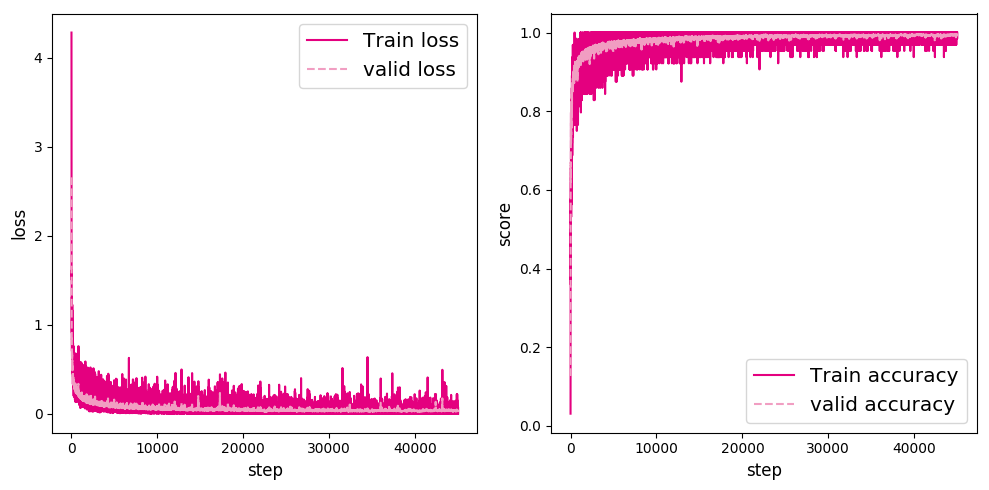

[Test] accuravy/loss: 0.8284/2.4534


In [48]:
# 打印训练集和验证集的损失 
plot(runner,fig_name='nnfigure')
# 加载训练好的模型
runner.load_model(model_saved_dir)
# 在测试集上对模型进行评价
score, loss = runner.evaluate([X_test_set, y_test_set])
print("[Test] accuravy/loss: {:.4f}/{:.4f}".format(score, loss))

## 4. Conclusion (5 points)

在本次试验中，我们不用自动求导的架构，全部自己实现数据处理、构建模型、损失函数、优化器，并自己实现反向传播，使用了KNN，Softmax回归，前馈神经网络三种方法，探究了一个基于Fashion-MNIST数据集的子集上的图像分类任务。

最后在使用各种方法（图像归一化正则化 + Kaiming He初始化 + SMOTE过采样 + 五层MLP(ReLU) + Momentum优化器 + Dropout层 + 随机小批量梯度下降），在测试集上准确率可以达到接近83%左右。（不同电脑不同随机数造成的初始化结果不同，可能结果有所差异）

但整体上，每使用一种方法，都会使得结果变得更好。虽然我的结果肯定不是SOTA，但是我很开心，能够一点点尝试不同方法，看着结果一点点进步！



#### 探索

在完成基本任务后，我还进行了如下探索：

1. 使用Xavier 和 Kaiming He 针对不同激活函数，对Linear层进行初始化
2. 对图像数据进行normalization归一化 和 standardization 标准化。
3. 使用小批量随机梯度下降法
4. 使用带有Momentum的优化器
5. 尝试更多层的前馈神经网络架构 如经典的5层MLP(在MNIST数据集上准确率可达97%)
6. 使用SMOTE等过采样算法解决类别不均衡问题
7. 尝试比较ReLU与sigmoid激活函数对模型的不同影响
8. 尝试在多层前馈神经网络中加入Dropout层。




#### 问题解决

本实验中，遇到过很多的问题，并逐一解决优化，记录部分思考过程如下：

1. KNN算法写错，准确率一开始只有10%
2. softmax回归中，softmax层的计算，换了写法，解决了可能的溢出问题
3. softmax回归中的交叉熵损失函数，计算loss，原版paddle书是用循环写的，整批梯度下降则巨慢无比(60000次迭代)，我自己改成了矩阵写法。
4. softmax回归的交叉熵损失函数是独立写的，并没有接上softmax层，这种写法有时候会造成了log(0.0)导致最后和label的0相乘造成nan的情况。我首先将其改写为加入了softmax层的交叉熵损失，再使用了在预测数值上加 1e-10这种极小数字的方法解决了问题。
5. 前馈神经网络中，在一般的框架下，最后一层的交叉熵损失函数是包含了softmax层的，又称softmax_crossentropy,经过查阅资料得知（见Reference）,此方法有两个优点：首先是能够用一些方法避免溢出，其次是其求导最后形式极其简洁！我曾经用循环自己实现了一个，很巨慢，后来加以改进，用了一种简洁高效的方法。
6. ReLU层的反向传播我一开始写错了，造成了很大困扰，最后加以修改。




#### 仍有待探索的问题

限制我的模型的主要问题有两个：

1. 是数据集的问题，数据集的类别不均衡问题非常严重！长尾效应显著。

就算使用SMOTE算法过采样，也很难得到很好的效果。就算我划分了验证集，问题在于，验证集来源于训练集，而训练集和测试集的分布明显是不一样的！

我也想下载完整Fashion-MNIST数据集pretrain一下，但我没有（doge）！

当下CV关于类别不均衡的SOTA方法是什么？

2， 是网络结构的问题，毕竟是最基础的前馈神经网络，做CV有更加适合的卷积神经网络，更适合提取图像各类局部性特征，而不是建立“全连接”的关系。本次实验是要求Fully Connected Network， 时间原因，没有用卷积尝试。

之前倒是在MNIST数据集上有过尝试，10轮epoch后准确率，FNN可以达到97%，两层卷积达到98%，简易GoogleNet（Inception）达到接近99%， Residual Net达到99%以上。

以后有时间会自己实现卷积做做尝试。




#### 收获

通过本次实验，把前馈神经网络好好搞了一遍，从底层一点点实现，也使用了诸多的trick,遇到了无数多的bug，消耗了很多时间，但是收获真的很大。

一点点使用不同方法，一点点看着模型进步。




#### 感谢

感谢邱锡鹏老师的教授，感谢李鹏助教在此次作业中对我的帮助！







## Reference
List your references here.

[1] Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv: https://arxiv.org/abs/1708.07747, GitHub: https://github.com/zalandoresearch/fashion-mnist

[2] 解决softmax交叉熵损失的溢出问题的方法 https://blog.csdn.net/muyuu/article/details/122757470

[3] softmax交叉熵损失函数的求导 https://blog.csdn.net/xiaocong1990/article/details/82464069/

[4] https://blog.csdn.net/mch2869253130/article/details/119809360

[5] https://blog.csdn.net/weixin_44042453/article/details/126215890

[6] https://imbalanced-learn.org/stable/over_sampling.html



